In [1]:
#!pip3 install pickle5
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [9]:
#from google.colab import drive
#drive.mount('/content/drive')
#!ls drive/'My Drive'
drive_path = 'C:/Users/simon/Nextcloud2/Master/Deep Learning/assignment/'
data_0_path = drive_path + "data_0.pickle"
data_1_path = drive_path + "data_1.pickle"

with open(data_0_path, "rb") as fh:
  data = pickle.load(fh)

In [3]:
with open(data_0_path, "rb") as fh:
  data2 = pickle.load(fh)

data = data.append(data2,ignore_index=True,verify_integrity=True)

In [15]:
z_acc=list()
speeds = list()
df_clean = pd.DataFrame(columns=["z","v"])

for d in data["GM.acc.xyz.z"]:
    z_acc.append(d.shape)
    
for d in data["GM.obd.spd_veh.value"]:
    speeds.append(d.shape)
    
speeds = np.array(speeds)
z_acc = np.array(z_acc)
k=0

all_accs, all_speeds = [],[]
l_mean = int(z_acc.mean())
speed_mean = int(np.array(speeds).mean())
inds_counter = []

for i in range(data["GM.acc.xyz.z"].shape[0]):
    if i%200==0:
        print("Current row acceleration: {}".format(i))
    if data["GM.obd.spd_veh.value"].iloc[i].mean()>1:
        xyz_acc_z = data.iloc[i]["GM.acc.xyz.z"]
        xyz_acc_z_list = list(xyz_acc_z)
        if xyz_acc_z.shape < l_mean+z_acc.std()/2 and xyz_acc_z.shape > l_mean-z_acc.std()/2:
            if xyz_acc_z.shape[0]>l_mean:
                for d in np.random.randint(0,l_mean,abs(l_mean-xyz_acc_z.shape[0])):
                    del xyz_acc_z_list[d]
                inds_counter.append(1)
                    
            elif xyz_acc_z.shape[0] < l_mean:
                while len(xyz_acc_z_list)!=l_mean:
                    r = np.random.randint(2,xyz_acc_z.shape[0]-2)
                    m = np.array(xyz_acc_z_list[r-2:r+2]).mean()
                    xyz_acc_z_list.insert(r,m)
                inds_counter.append(1)
            else:
                inds_counter.append(0)
                
            k+=1
            all_accs.append(xyz_acc_z_list)
            
        else:
            inds_counter.append(0)
    else:
        inds_counter.append(0)
                
            
for i in range(data["GM.obd.spd_veh.value"].shape[0]):
    if i%200==0:
        print("Current row speed: {}".format(i))

    if inds_counter[i]==1:
        veh_speed = data["GM.obd.spd_veh.value"].iloc[i]
        veh_speed_list = list(veh_speed)
        if veh_speed.shape[0]>speed_mean:
            for d in np.random.randint(0,speed_mean-1,abs(speed_mean-veh_speed.shape[0])):
                del veh_speed_list[d]
        
        if veh_speed.shape[0]<speed_mean:
            while len(veh_speed_list)!=speed_mean:
                if veh_speed.shape[0]>3:
                    r = np.random.randint(2,veh_speed.shape[0]-2)
                    m = np.array(veh_speed_list[r-2:r+2]).mean()
                else:
                    r = veh_speed.shape[0]//2
                    m = veh_speed.mean()
                veh_speed_list.insert(r,m)
                
        k+=1
        all_speeds.append(veh_speed_list)
        
all_speeds_smooth = []
for v in all_speeds:
    v = np.convolve(np.array(v),np.ones(7)/7,"valid")
    all_speeds_smooth.append(v)

all_accs_smooth = []
for z in all_accs:
    z = np.convolve(np.array(z),np.ones(21)/21,"valid")
    all_accs_smooth.append(z)


print("Fitting scaler")
scaler_accs = StandardScaler().fit(all_accs)
scaler_speeds = StandardScaler().fit(all_speeds)
scaler_accs_smooth = StandardScaler().fit(all_accs_smooth)
scaler_speeds_smooth = StandardScaler().fit(all_speeds_smooth)

print("transforming data with standard scaler")
all_accs = scaler_accs.transform(all_accs)
all_speeds = scaler_speeds.transform(all_speeds)
all_accs_smooth = scaler_accs_smooth.transform(all_accs_smooth)
all_speeds_smooth = scaler_speeds_smooth.transform(all_speeds_smooth)


df_clean["v"] = all_speeds.tolist()
df_clean["z"] = all_accs.tolist()
df_clean["z_smooth"] = all_accs_smooth.tolist()
df_clean["v_smooth"] = all_speeds_smooth.tolist()

df_clean["IRI_Sequence"] = data["IRI_sequence"]
df_clean["IRI_mean"] = data["IRI_mean"]

print("transforming data type to np.array")
for i in range(df_clean["v"].shape[0]):
    for c in ["z","v","z_smooth","v_smooth"]:
        df_clean[c].iloc[i] = np.array(df_clean[c].iloc[i])
    

Current row acceleration: 0
Current row acceleration: 200
Current row acceleration: 400
Current row acceleration: 600
Current row acceleration: 800
Current row acceleration: 1000
Current row acceleration: 1200
Current row acceleration: 1400
Current row acceleration: 1600
Current row acceleration: 1800
Current row acceleration: 2000
Current row acceleration: 2200
Current row speed: 0
Current row speed: 200
Current row speed: 400
Current row speed: 600
Current row speed: 800
Current row speed: 1000
Current row speed: 1200
Current row speed: 1400
Current row speed: 1600
Current row speed: 1800
Current row speed: 2000
Current row speed: 2200
Fitting scaler
transforming data with standard scaler
transforming data type to np.array


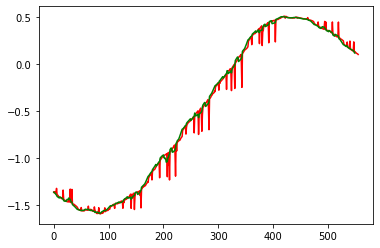

In [11]:
plt.plot(df_clean["v"][0],c="r")
plt.plot(df_clean["v_smooth"][0],c="g")

In [17]:
df_clean.head(5)
ls = np.array([df_clean["z"][i].shape for i in range(df_clean["z"].shape[0])])
print("average length of z-acc: {}, std of z-acc: {}".format(ls.mean(),ls.std()))
ls = np.array([df_clean["v"][i].shape for i in range(df_clean["v"].shape[0])])
print("average length of z-acc: {}, std of z-acc: {}".format(ls.mean(),ls.std()))
print("Rows dropped: {}".format(np.where(np.array([inds_counter])==0)[0].shape))
df_clean.head()

average length of z-acc: 3085.0, std of z-acc: 0.0
average length of z-acc: 556.0, std of z-acc: 0.0
Rows dropped: (745,)


,z,v,z_smooth,v_smooth,IRI_Sequence,IRI_mean
0,"[-0.5847926252276651, -0.563005079050583, -0.5...","[-1.3587954164799863, -1.3695510263755228, -1....","[-0.24720147779942403, -0.22350775093934816, -...","[-1.362943270544927, -1.3663861359934661, -1.3...","[6.644882798499999, 5.5573473115, 7.666319952,...",4.93354
1,"[-0.5847926252276651, -0.563005079050583, -0.5...","[-1.5246014975095756, -1.5359615717114699, -1....","[-1.3560408395749142, -1.3940539889090402, -1....","[-1.538313585562642, -1.5407407388997318, -1.5...","[5.5573473115, 7.666319952, 4.1605364705, 5.35...",4.696225
2,"[0.9819588948256633, 0.9642479075833269, 0.983...","[-1.4635150466039373, -1.4637043612366507, -1....","[2.1419716294015787, 2.300206689316816, 2.4618...","[-1.4740261289813823, -1.4711025870769254, -1....","[7.666319952, 4.1605364705, 5.359907053000001,...",4.699145
3,"[0.9819588948256633, 0.9642479075833269, -0.39...","[-0.7184785114512424, -0.7126672947862575, -0....","[0.9894499144161831, 1.0272480307009386, 1.067...","[-0.7046079380830329, -0.7001968014430378, -0....","[4.1605364705, 5.359907053000001, 4.5512844555...",4.397566
4,"[-1.1392905276561773, -0.024786406050078313, -...","[-0.25051266433483554, -0.24518503913856332, -...","[-2.7253851834641094, -2.8242059982791474, -2....","[-0.24313888615883905, -0.2415230944764022, -0...","[5.359907053000001, 4.5512844555, 5.8527534034...",4.400549


In [16]:
from sklearn.model_selection import train_test_split
df = pd.DataFrame(columns=["train","test"])

train,test = train_test_split(df_clean, test_size=0.1)
data_dict = {"train":train,"test":test}

drive_path = 'C:/Users/simon/Nextcloud2/Master/Deep Learning/assignment/'
data_0_path = drive_path + "dataset_smol_boi.pickle"
with open(data_0_path, 'wb') as handle:
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)